In [44]:
# math 
import numpy as np
from scipy.linalg import norm

# random
from numpy.random import rand, randn
np.random.seed(6)

# plotting
import matplotlib.pyplot as plt

# robust regression 
from sklearn.linear_model import LinearRegression, Lasso, Ridge

ImportError: cannot import name 'sprandn' from 'numpy.random' (/Users/madeleine/opt/anaconda3/envs/orie4741/lib/python3.9/site-packages/numpy/random/__init__.py)

In [4]:
def generate_data(n, w):
    X = randn(n,len(w))
    y = X@w
    return X, y

def generate_noisy_data(n, w):
    X = randn(n,len(w))
    y = X@w + .1*randn(n)
    return X, y

# OLS is invariant

In [17]:
d = 10
n = 20
w = randn(d)
X, y = generate_data(n, w);

In [29]:
LinearRegression?

In [26]:
lin = LinearRegression().fit(X,y)
yhat = lin.predict(X)
yhat

array([-0.71420156, -1.63516395, -3.8608605 , -0.57894597,  6.59638624,
       -4.79152845, -0.5736281 ,  5.18756905, -7.26414655,  5.32047682,
        3.56641161, -0.245102  ,  1.61110249,  2.61211864, -3.38682977,
        1.19532532,  4.86224655,  6.26788358,  4.48640507, -3.14514452])

In [27]:
yscale = 5*y
Xscale = 3*X
lin = LinearRegression().fit(Xscale,yscale)
yhatscale = lin.predict(Xscale)
yhatscale

array([ -3.57100781,  -8.17581975, -19.30430252,  -2.89472986,
        32.98193119, -23.95764226,  -2.8681405 ,  25.93784523,
       -36.32073277,  26.6023841 ,  17.83205803,  -1.22551002,
         8.05551247,  13.06059321, -16.93414883,   5.9766266 ,
        24.31123275,  31.33941792,  22.43202537, -15.72572261])

In [28]:
# predictions match up to scaling
norm(yhat - yhatscale/5)

2.4221204859038887e-14

# ridge regression is not scaling invariant

In [42]:
Ridge?

In [38]:
alpha = .1 # regularization parameter

lin = Ridge(alpha=alpha).fit(X,y)
yhat = lin.predict(X)
yhat

array([-0.73252921, -1.61138302, -3.871725  , -0.59222297,  6.55771702,
       -4.72195274, -0.56508244,  5.18633252, -7.21591302,  5.28679447,
        3.54741707, -0.21884335,  1.60849856,  2.58391179, -3.40339278,
        1.19486892,  4.83695027,  6.26115137,  4.48779252, -3.108016  ])

In [39]:
yscale = 5*y
Xscale = 3*X
lin = Ridge(alpha=alpha).fit(Xscale,yscale)
yhatscale = lin.predict(Xscale)
yhatscale

array([ -3.58216226,  -8.16285939, -19.31217038,  -2.90274427,
        32.95995686, -23.91745638,  -2.8628421 ,  25.93815093,
       -36.29302326,  26.58314257,  17.82078142,  -1.20993494,
         8.0550225 ,  13.04380232, -16.94425996,   5.97684365,
        24.29672683,  31.33609432,  22.43311342, -15.70431196])

In [40]:
# predictions do not match up to scaling
norm(yhat - yhatscale/5)

0.10923658080907492

In [43]:
# standardize

lin = Ridge(alpha=alpha, normalize=True).fit(X,y)
yhat = lin.predict(X)
yhat

yscale = 5*y
Xscale = 3*X
lin = Ridge(alpha=alpha, normalize=True).fit(Xscale,yscale)
yhatscale = lin.predict(Xscale)
yhatscale

# predictions match up to scaling
norm(yhat - yhatscale/5)

7.1041804156888074e-15

# let's compare different kinds of regularized regression

In [51]:
# generate data

d = 30
w_randn = randn(d)
w_sparse = w_randn*(abs(w_randn) > 1)
w_pos = w_randn*(w_randn > 0)

In [47]:
w_pos

array([-0.        , -0.        ,  0.85724762,  0.94309899,  0.11444143,
       -0.        , -0.        , -0.        , -0.        ,  0.23371059,
        1.38503523, -0.        , -0.        ,  0.95560959, -0.        ,
       -0.        ,  1.21848065, -0.        , -0.        , -0.        ,
        0.35877096,  1.07368134, -0.        ,  0.39636757, -0.        ,
        2.33660781,  1.50278553, -0.        ,  0.52834106,  0.9398248 ])

In [52]:
w_sparse

array([ 0.        , -0.        , -0.        ,  0.        ,  1.90474232,
        0.        , -0.        ,  1.66284285,  0.        , -0.        ,
       -0.        ,  0.        ,  0.        , -0.        , -1.91402115,
       -0.        ,  0.        , -0.        , -0.        , -1.07282736,
       -0.        ,  1.36293786,  0.        , -1.6326206 ,  0.        ,
       -0.        ,  2.33903423, -0.        , -0.        ,  0.        ])

In [53]:
# find best model for each type of data
w = w_randn

alpha_ridge=.1
alpha_lasso=.1

X,y = generate_data(30, w)
w_ridge = Ridge(alpha = alpha_ridge).fit(X,y).coef_
w_lasso = Lasso(alpha = alpha_lasso).fit(X,y).coef_
w_nonneg = LinearRegression(positive=True).fit(X,y).coef_

(array([1., 0., 1., 1., 2., 0., 3., 3., 4., 4., 5., 1., 0., 1., 0., 1., 1.,
        0., 1., 1.]),
 array([-1.94753674, -1.73867147, -1.5298062 , -1.32094093, -1.11207566,
        -0.90321039, -0.69434512, -0.48547985, -0.27661458, -0.06774931,
         0.14111596,  0.34998123,  0.5588465 ,  0.76771177,  0.97657703,
         1.1854423 ,  1.39430757,  1.60317284,  1.81203811,  2.02090338,
         2.22976865]),
 <BarContainer object of 20 artists>)

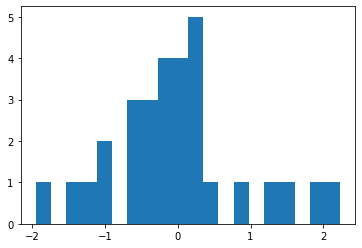

In [56]:
plt.hist(w_ridge, label="ridge coefficients", bins=20)

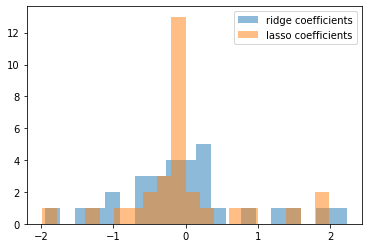

In [60]:
plt.hist(w_ridge, label="ridge coefficients", bins=20, alpha=.5)
plt.hist(w_lasso, label="lasso coefficients", bins=20, alpha=.5)
plt.legend()

Which coefficients are more sparse? (More 0 coefficients)
* A) ridge
* B) lasso

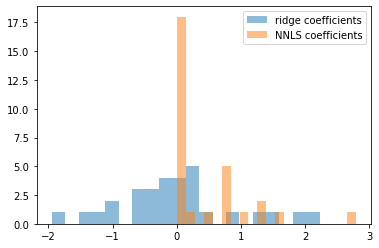

In [61]:
plt.hist(w_ridge, label="ridge coefficients", bins=20, alpha=.5)
plt.hist(w_nonneg, label="NNLS coefficients", bins=20, alpha=.5)
plt.legend()

Which coefficients are more sparse? (More 0 coefficients)
* A) ridge
* B) nonnegative least squares

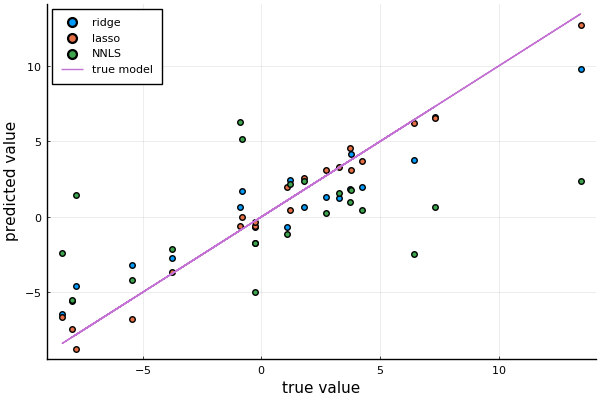

In [17]:
# which fits data best?
Xtest,ytest = generate_data(20,w)

scatter(ytest,Xtest*w_ridge,label="ridge")
scatter!(ytest,Xtest*w_lasso,label="lasso")
scatter!(ytest,Xtest*w_nonneg,label="NNLS")
plot!(ytest,ytest,label="true model")
xlabel!("true value")
ylabel!("predicted value")

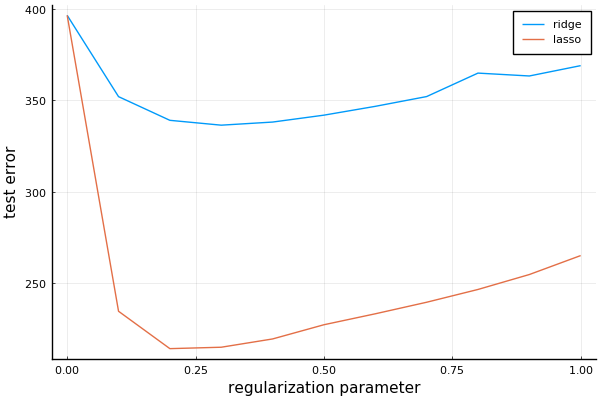

In [18]:
# cross validate over lambda
Random.seed!(1)

w = randn(40)
X,y = generate_noisy_data(30, w)
Xtest,ytest = generate_noisy_data(30, w)

ridge_error = Float64[]
lasso_error = Float64[]
λs = 0:.1:1
for λ in λs
    w = ridge_regression(X,y; λ=λ)
    push!(ridge_error, sum((ytest - Xtest*w).^2))
    w = lasso(X,y; λ=λ)
    push!(lasso_error, sum((ytest - Xtest*w).^2))
end
plot(λs, ridge_error, label="ridge")
plot!(λs, lasso_error, label="lasso")
ylabel!("test error")
xlabel!("regularization parameter")